In [69]:
import pandas as pd

# Assuming your notebook is in the 'notebooks' subfolder and data in the 'data' subfolder
df = pd.read_csv(r'C:\Users\songt\OneDrive\Máy tính\CIS4915\Toan\data.csv')


In [70]:
# Set display options to show all columns (None means unrestricted)
pd.set_option('display.max_columns', None)

In [71]:
# Count unique values in the 'Pidm' column
unique_pidm_count = df['Pidm'].nunique()
print(f'Number of unique Pidm values: {unique_pidm_count}')

Number of unique Pidm values: 105883


In [72]:
# Check unique admission descriptions
print(df['Admit_Desc'].unique())

['Former USF Student Returning' 'Second Baccalaureate'
 'Fl Comm Coll Transf-Upper Levl' 'Other UG Transf - Upper Level'
 'Beginner(FTIC) - Lower Level' 'Fl Comm Coll Transf-Lower Levl'
 'Other UG Transf - Lower Level' 'Early Admit - Lower Level'
 'Beginner(FTIC) - w/ AA']


In [73]:
# Drop duplicates to ensure each Pidm and Admit_Desc combination is unique
df_unique = df.drop_duplicates(subset=['Pidm', 'Admit_Desc'])

In [74]:
# Count the number of unique Pidms for each admission type
admission_counts = df_unique['Admit_Desc'].value_counts()

# Print the results
print(admission_counts)


Beginner(FTIC) - Lower Level      65772
Fl Comm Coll Transf-Upper Levl    17779
Other UG Transf - Lower Level      7912
Former USF Student Returning       5625
Other UG Transf - Upper Level      4014
Fl Comm Coll Transf-Lower Levl     3783
Second Baccalaureate               3763
Early Admit - Lower Level            90
Beginner(FTIC) - w/ AA               31
Name: Admit_Desc, dtype: int64


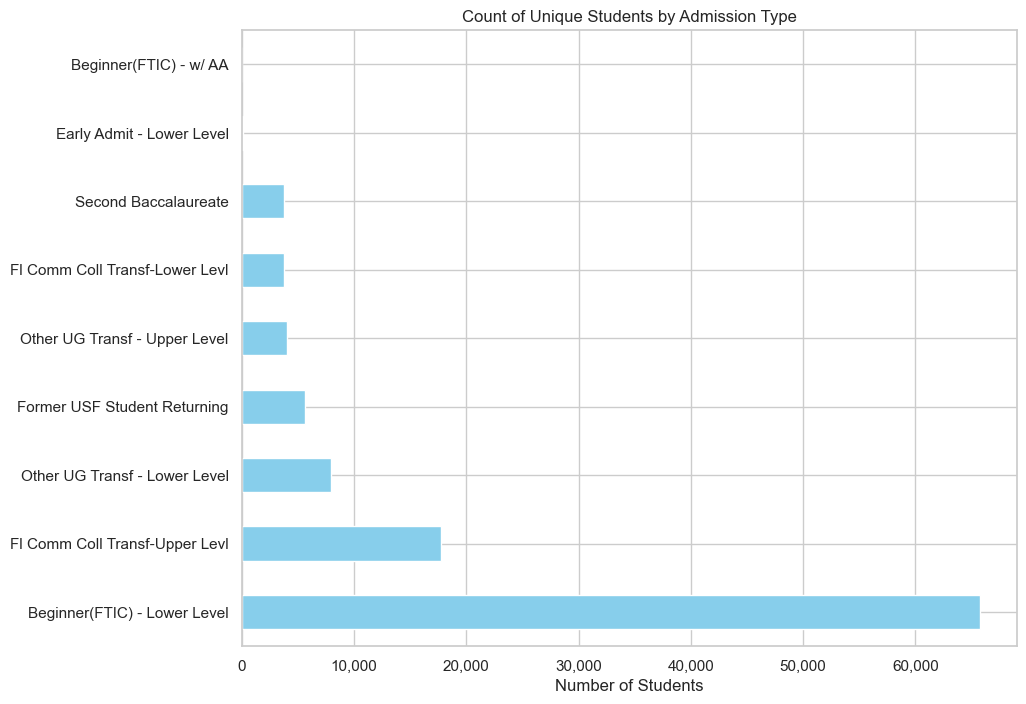

In [75]:
fig, ax = plt.subplots(figsize=(10, 8))
admission_counts.plot(kind='barh', color='skyblue', ax=ax)

ax.set_xlabel('Number of Students')
ax.set_title('Count of Unique Students by Admission Type')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format the x-axis labels to have commas, no decimals

plt.show()

In [76]:
# Assuming 'Final_GPA' is a column with academic performance data
# Group by major and calculate average GPA for each major
average_gpa_by_major = df_unique.groupby('Major_Desc')['Final_GPA'].mean()

# Print the results
print(average_gpa_by_major)

Major_Desc
ASL Interpreting                3.899487
Accounting                      3.463040
Advertising (Pre)               3.781129
Africana Studies                3.340000
Aging Sciences                  3.612500
                                  ...   
Undeclared Major                3.727197
Undergraduate Studies           3.277059
Women's and Gender Studies      3.760488
World Languages & Cultures      3.778744
World Languages and Cultures    3.580417
Name: Final_GPA, Length: 182, dtype: float64


In [77]:
# Group by Pidm and Term, and count the number of courses per term for each student
course_counts_per_term = df.groupby(['Pidm', 'Term']).size().reset_index(name='Courses_Per_Term')

In [78]:
course_counts_per_term.head()

,Pidm,Term,Courses_Per_Term
0,285,202101.0,4
1,285,202105.0,1
2,432,201908.0,3
3,705,202208.0,6
4,794,201508.0,3


In [79]:
# Merge the course count per term back with the main dataframe to get GPA data
df = df.merge(course_counts_per_term, on=['Pidm', 'Term'])

# Optionally, you can clean or process GPA data if necessary (e.g., converting to numeric if it's not already)
df['Final_GPA'] = pd.to_numeric(df['Final_GPA'], errors='coerce')


In [80]:
# Filter data into more than 5 courses and 5 or fewer courses
more_than_five = df[df['Courses_Per_Term'] > 5]
five_or_fewer = df[df['Courses_Per_Term'] <= 5]

# Calculate average GPA for both groups
avg_gpa_more_than_five = more_than_five['Final_GPA'].mean()
avg_gpa_five_or_fewer = five_or_fewer['Final_GPA'].mean()

print(f"Average GPA for students taking more than 5 courses per term: {avg_gpa_more_than_five}")
print(f"Average GPA for students taking 5 or fewer courses per term: {avg_gpa_five_or_fewer}")


Average GPA for students taking more than 5 courses per term: 3.9354302493132858
Average GPA for students taking 5 or fewer courses per term: 3.740880585694878


In [81]:
from scipy.stats import ttest_ind

# Perform t-test
t_stat, p_val = ttest_ind(more_than_five['Final_GPA'].dropna(), five_or_fewer['Final_GPA'].dropna(), equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_val}")


T-statistic: 205.79578841597927, P-value: 0.0


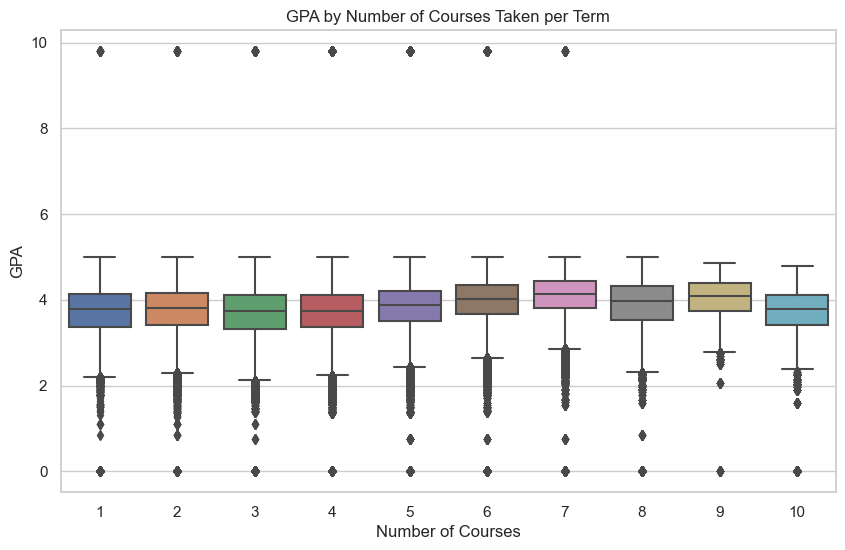

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Courses_Per_Term', y='Final_GPA', data=df[df['Courses_Per_Term'] <= 10])  # Limiting to 10 courses for visualization clarity
plt.title('GPA by Number of Courses Taken per Term')
plt.xlabel('Number of Courses')
plt.ylabel('GPA')
plt.show()


In [84]:
# Identify drop and fail cases
df['Is_Dropped'] = df['SHRTCKG_GRDE_CODE_FINAL'].apply(lambda x: 1 if x == 'W' else 0)
df['Is_Failed'] = df['SHRTCKG_GRDE_CODE_FINAL'].apply(lambda x: 1 if x == 'F' else 0)

In [85]:
# Calculate drop and fail rates by course
course_stats = df.groupby(['SUBJ', 'CRSE_NUMB']).agg({
    'Is_Dropped': 'sum',
    'Is_Failed': 'sum',
    'Pidm': 'count'  # Total enrollments
}).rename(columns={'Pidm': 'Total_Enrollments'})

# Calculate rates
course_stats['Drop_Rate'] = course_stats['Is_Dropped'] / course_stats['Total_Enrollments']
course_stats['Fail_Rate'] = course_stats['Is_Failed'] / course_stats['Total_Enrollments']

# Reset index for better readability in output
course_stats.reset_index(inplace=True)


In [86]:
# Sorting courses by highest drop rate
highest_drop_rates = course_stats.sort_values(by='Drop_Rate', ascending=False).head(10)

# Sorting courses by highest fail rate
highest_fail_rates = course_stats.sort_values(by='Fail_Rate', ascending=False).head(10)


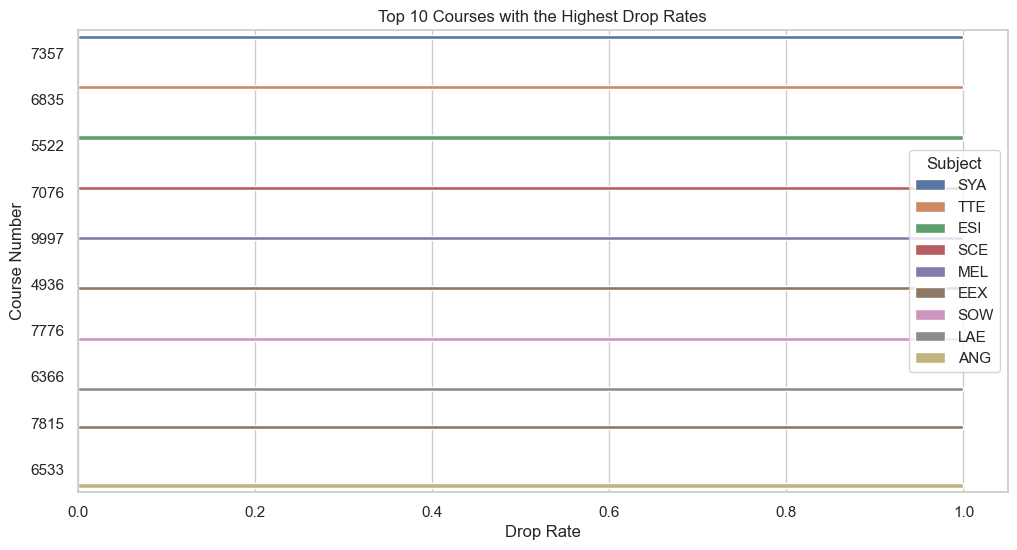

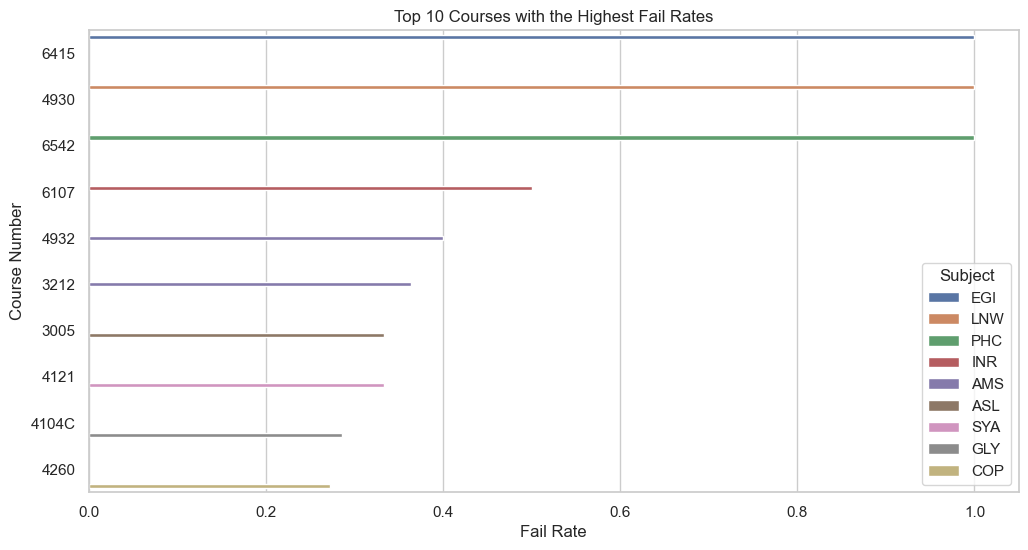

In [87]:
# Visualizing drop rates
plt.figure(figsize=(12, 6))
sns.barplot(x='Drop_Rate', y='CRSE_NUMB', hue='SUBJ', data=highest_drop_rates)
plt.title('Top 10 Courses with the Highest Drop Rates')
plt.xlabel('Drop Rate')
plt.ylabel('Course Number')
plt.legend(title='Subject')
plt.show()

# Visualizing fail rates
plt.figure(figsize=(12, 6))
sns.barplot(x='Fail_Rate', y='CRSE_NUMB', hue='SUBJ', data=highest_fail_rates)
plt.title('Top 10 Courses with the Highest Fail Rates')
plt.xlabel('Fail Rate')
plt.ylabel('Course Number')
plt.legend(title='Subject')
plt.show()
